In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
train_csv = pd.read_csv("./fashion-mnist_train.csv")
test_csv = pd.read_csv("./fashion-mnist_test.csv")

In [4]:
import random
 
class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, data, corruption_rate,transform = None):
        """Method to initilaize variables.""" 
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.fashion_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')
#         print(self.labels)
        corruption_index = random.sample(range(1, len(self.labels)), int(len(self.labels)*corruption_rate))
#         print(corruption_index)
#         print(self.labels[corruption_index])
        self.labels[corruption_index] = (self.labels[corruption_index]+1)%10
#         print(self.labels[corruption_index])
        print(len(corruption_index))
        
        
    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [5]:
train_set = FashionDataset(train_csv, corruption_rate=0.3, transform=transforms.Compose([transforms.ToTensor()]))
test_set = FashionDataset(test_csv, corruption_rate=0,  transform=transforms.Compose([transforms.ToTensor()]))


train_loader = DataLoader(train_set, batch_size=64)

test_loader = DataLoader(test_set, batch_size=64)

18000
0


In [9]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out


In [10]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()


optimizer = torch.optim.Adam(model.parameters(), lr= 0.0005)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [11]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(-1, 1, 28, 28))
        labels = Variable(labels)

        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(-1, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))


Iteration: 50, Loss: 1.3054170608520508, Accuracy: 70%
Iteration: 100, Loss: 1.0984824895858765, Accuracy: 72%
Iteration: 150, Loss: 1.13750422000885, Accuracy: 72%
Iteration: 200, Loss: 1.2899326086044312, Accuracy: 75%
Iteration: 250, Loss: 1.1517395973205566, Accuracy: 75%
Iteration: 300, Loss: 1.1425652503967285, Accuracy: 71%
Iteration: 350, Loss: 1.0326789617538452, Accuracy: 76%
Iteration: 400, Loss: 1.0379301309585571, Accuracy: 70%
Iteration: 450, Loss: 1.1679595708847046, Accuracy: 73%
Iteration: 500, Loss: 1.1760869026184082, Accuracy: 80%
Iteration: 550, Loss: 1.0734575986862183, Accuracy: 76%
Iteration: 600, Loss: 1.0259175300598145, Accuracy: 78%
Iteration: 650, Loss: 0.946176290512085, Accuracy: 76%
Iteration: 700, Loss: 1.0907738208770752, Accuracy: 79%
Iteration: 750, Loss: 1.009406566619873, Accuracy: 74%
Iteration: 800, Loss: 1.1594483852386475, Accuracy: 76%
Iteration: 850, Loss: 1.0026648044586182, Accuracy: 75%
Iteration: 900, Loss: 1.0064709186553955, Accuracy: 7

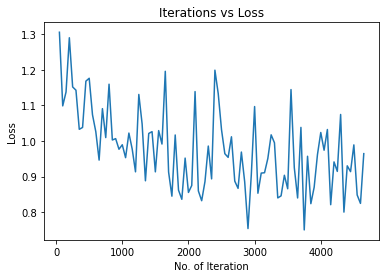

In [12]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

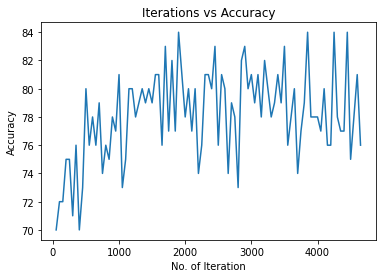

In [13]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [18]:
model = FashionCNN()
model.to(device)

import torch.optim as optim
import math


# fai    =  np.zeros(batch_size) #final error density
# IC     =  np.zeros(batch_size)

h=0.1
delta=3
# batch_size=64
lamb=1

class CustomCrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super(CustomCrossEntropyLoss, self).__init__()

    def forward(self, inputs, targets):
        batch_size=len(inputs)
        fai    =  np.zeros(batch_size) 
        # 手动实现交叉熵损失函数
        log_softmax = inputs.log_softmax(dim=1)
        # loss = -log_softmax[torch.arange(log_softmax.size(0)), targets].mean()
        loss = -log_softmax[torch.arange(log_softmax.size(0)), targets]
        IC=loss-loss
        # print(loss)
        for i in range(batch_size):
            for j in range(batch_size):
                fai[i]  = fai[i]  + (1/(batch_size*h))* math.exp((loss[i]-loss[j])**2/(-2*h*h))
#             IC[i]   = (1-math.exp((1-lamb+fai[i])**2/(-2*delta*delta)))/(1-math.exp(1/(-2*delta*delta)))
#             lamb = fai.max()*0.95
            IC[i]   = 1 / (1 + math.exp(-delta * (fai[i] - lamb)))
        loss_EDERM = (loss*IC).mean()
#         print(fai)
#         print("IC",IC)
#         print("loss",loss)
#         print(loss*IC)
        return loss_EDERM

error   = CustomCrossEntropyLoss() # 创建损失函数

# error = nn.CrossEntropyLoss()

optimizer = optim.RMSprop(model.parameters(), lr=0.0005, momentum=0.9)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [ ]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(-1, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(-1, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
#             print("Iteration: {}, Loss: {}, Accuracy: {}%, fai:{}, batchloss:{},IC:{}".format(count, loss.data, accuracy,fai,losses,IC))
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))


Iteration: 50, Loss: 0.5334485769271851, Accuracy: 52%
Iteration: 100, Loss: 0.2979891300201416, Accuracy: 62%
Iteration: 150, Loss: 0.2945244610309601, Accuracy: 61%
Iteration: 200, Loss: 0.22874918580055237, Accuracy: 69%
Iteration: 250, Loss: 0.2490035593509674, Accuracy: 73%
Iteration: 300, Loss: 0.25843098759651184, Accuracy: 75%
Iteration: 350, Loss: 0.2563641369342804, Accuracy: 70%
Iteration: 400, Loss: 0.23088125884532928, Accuracy: 77%
Iteration: 450, Loss: 0.3752119541168213, Accuracy: 76%
Iteration: 500, Loss: 0.25852054357528687, Accuracy: 79%
Iteration: 550, Loss: 0.2722333073616028, Accuracy: 77%
Iteration: 600, Loss: 0.23381586372852325, Accuracy: 81%
Iteration: 650, Loss: 0.19812838733196259, Accuracy: 82%
Iteration: 700, Loss: 0.205873042345047, Accuracy: 81%
Iteration: 750, Loss: 0.19635918736457825, Accuracy: 82%
Iteration: 800, Loss: 0.2438068687915802, Accuracy: 82%
Iteration: 850, Loss: 0.24344943463802338, Accuracy: 84%
Iteration: 900, Loss: 0.22459200024604797,